C:\Users\Vinay\AppData\Local\Temp\ipykernel_2900\3340349570.py:187: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(top_df_after['CVE ID'], rotation=45, ha='right')


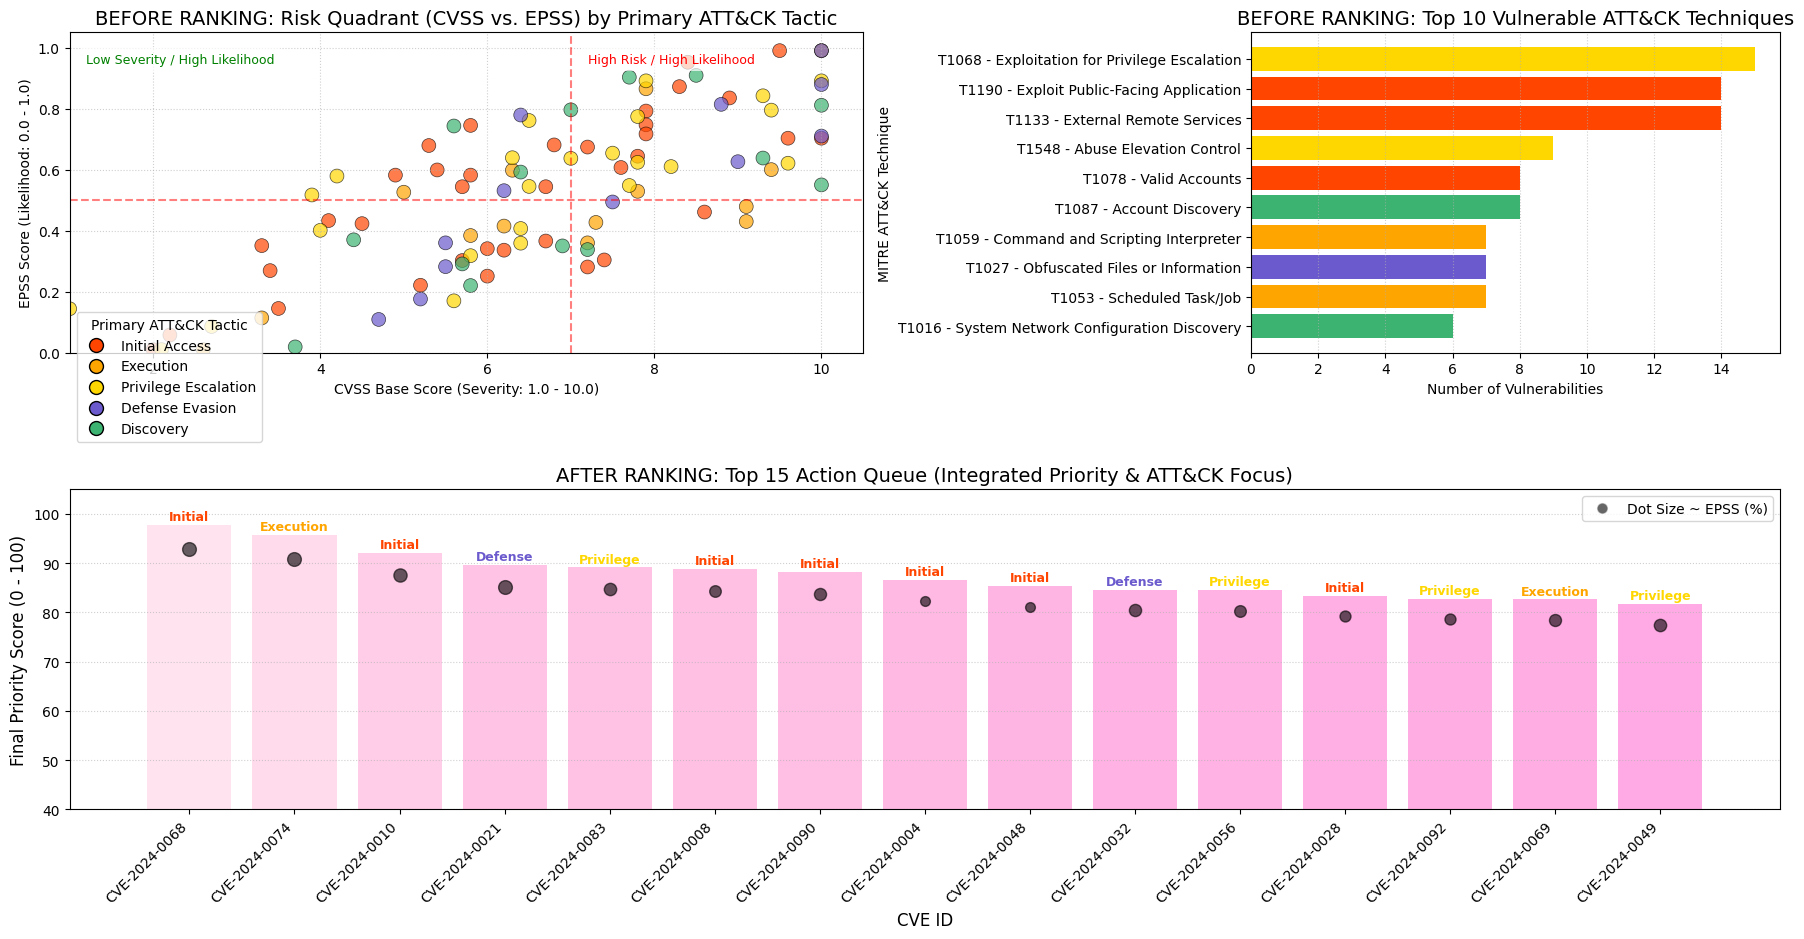


--- Top 5 Vulnerabilities from the Integrated Priority Score (with ATT&CK) ---
          CVE ID  CVSS  EPSS        Primary Tactic  \
0  CVE-2024-0068   9.5  99.0        Initial Access   
1  CVE-2024-0074  10.0  99.0             Execution   
2  CVE-2024-0010   8.4  95.2        Initial Access   
3  CVE-2024-0021  10.0  99.0       Defense Evasion   
4  CVE-2024-0083  10.0  89.1  Privilege Escalation   

                                   Technique  Priority Score  
0           T1133 - External Remote Services            97.8  
1  T1059 - Command and Scripting Interpreter            95.6  
2  T1190 - Exploit Public-Facing Application            92.1  
3    T1027 - Obfuscated Files or Information            89.6  
4            T1548 - Abuse Elevation Control            89.1  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

# --- 1. Data Generation (Simulating Synchronized Data with MITRE ATT&CK) ---

np.random.seed(42)
random.seed(42) # For Python's random module
N_VULNS = 100

# CVSS (Severity) - Range 1.0 to 10.0
cvss_scores = np.clip(np.random.normal(loc=7.0, scale=2.5, size=N_VULNS), 1.0, 10.0)

# EPSS (Likelihood) - Range 0.0 to 1.0 (0% to 100%)
epss_scores = np.clip(cvss_scores / 10.0 * 0.8 + np.random.uniform(-0.3, 0.3, N_VULNS), 0.01, 0.99)

# MITRE ATT&CK Tactic and Techniques (new data)
# Simplified mapping: each vuln gets a primary Tactic and a Technique
mitre_tactics = {
    'Initial Access': ['T1190 - Exploit Public-Facing Application', 'T1078 - Valid Accounts', 'T1133 - External Remote Services'],
    'Execution': ['T1059 - Command and Scripting Interpreter', 'T1053 - Scheduled Task/Job'],
    'Privilege Escalation': ['T1068 - Exploitation for Privilege Escalation', 'T1548 - Abuse Elevation Control'],
    'Defense Evasion': ['T1027 - Obfuscated Files or Information', 'T1036 - Masquerading'],
    'Discovery': ['T1087 - Account Discovery', 'T1016 - System Network Configuration Discovery']
}

primary_tactics = random.choices(list(mitre_tactics.keys()), k=N_VULNS, weights=[0.3, 0.2, 0.2, 0.15, 0.15])
techniques = []
for tactic in primary_tactics:
    techniques.append(random.choice(mitre_tactics[tactic]))

# --- 2. Integration Step (Calculating the Final Priority Score with Tactic Weight) ---
# A simple weighted formula to combine severity, likelihood, and tactic impact

WEIGHT_EPSS = 0.45
WEIGHT_CVSS = 0.35
WEIGHT_MITRE_TACTIC = 0.2 # New weight for Tactic impact

# Assign a numerical factor to Tactics for scoring (e.g., Initial Access is highest impact)
tactic_impact_factors = {
    'Initial Access': 1.0,
    'Execution': 0.8,
    'Privilege Escalation': 0.7,
    'Defense Evasion': 0.5,
    'Discovery': 0.3
}
tactic_scores = np.array([tactic_impact_factors[tactic] for tactic in primary_tactics])

final_priority_score = (
    (epss_scores * WEIGHT_EPSS) +
    (cvss_scores / 10.0 * WEIGHT_CVSS) +
    (tactic_scores * WEIGHT_MITRE_TACTIC)
) * 100 # Scale to 0-100

# Create a DataFrame for easy handling
df = pd.DataFrame({
    'CVE ID': [f'CVE-2024-{i:04d}' for i in range(1, N_VULNS + 1)],
    'CVSS': cvss_scores.round(1),
    'EPSS': (epss_scores * 100).round(1), # Convert to percentage for display
    'Primary Tactic': primary_tactics,
    'Technique': techniques,
    'Priority Score': final_priority_score.round(1)
}).sort_values(by='Priority Score', ascending=False).reset_index(drop=True)


# --- 3. Matplotlib Visualization ---

# Define a color map for MITRE ATT&CK Tactics
tactic_colors = {
    'Initial Access': '#FF4500', # Red
    'Execution': '#FFA500',      # Orange
    'Privilege Escalation': '#FFD700', # Gold
    'Defense Evasion': '#6A5ACD', # Slate Blue
    'Discovery': '#3CB371'       # Medium Sea Green
}
tactic_labels = list(tactic_colors.keys())

# Create a figure with a GridSpec for better layout control
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1.2, 0.8])

# =======================================================
# BEFORE RANKING - Panel 1: Risk Quadrant Scatter Plot (Analysis View)
# =======================================================
ax1 = fig.add_subplot(gs[0, 0])

# Map Tactics to colors for scatter plot
tactic_color_map = [tactic_colors[tactic] for tactic in df['Primary Tactic']]

scatter = ax1.scatter(
    df['CVSS'],
    df['EPSS'] / 100, # Use 0.0-1.0 range for plot
    c=tactic_color_map,
    s=100, # Size of the dots
    alpha=0.7,
    edgecolors='k',
    linewidths=0.5
)

# Add Quadrant Lines (The "Triage Matrix")
ax1.axvline(7.0, color='r', linestyle='--', alpha=0.5)
ax1.axhline(0.50, color='r', linestyle='--', alpha=0.5)

# Add Quadrant Text Labels
ax1.text(7.2, 0.95, 'High Risk / High Likelihood', color='red', fontsize=9, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
ax1.text(1.2, 0.95, 'Low Severity / High Likelihood', color='green', fontsize=9, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Labels and Title
ax1.set_title('BEFORE RANKING: Risk Quadrant (CVSS vs. EPSS) by Primary ATT&CK Tactic', fontsize=14)
ax1.set_xlabel('CVSS Base Score (Severity: 1.0 - 10.0)')
ax1.set_ylabel('EPSS Score (Likelihood: 0.0 - 1.0)')
ax1.set_xlim(1, 10.5)
ax1.set_ylim(0, 1.05)
ax1.grid(True, linestyle=':', alpha=0.6)

# Custom Legend for ATT&CK Tactics
legend_elements_tactic = [plt.Line2D([0], [0], marker='o', color='w', label=tactic,
                                     markerfacecolor=tactic_colors[tactic], markersize=10, markeredgecolor='k')
                          for tactic in tactic_labels]
ax1.legend(handles=legend_elements_tactic, title='Primary ATT&CK Tactic', loc='lower left', bbox_to_anchor=(0.0, -0.3))


# =======================================================
# BEFORE RANKING - Panel 2: ATT&CK Technique Distribution (Analysis View)
# =======================================================
ax2 = fig.add_subplot(gs[0, 1])

# Calculate top N techniques
top_techniques = df['Technique'].value_counts().nlargest(10)
top_techniques_tactic = df[df['Technique'].isin(top_techniques.index)].drop_duplicates('Technique').set_index('Technique')['Primary Tactic']

# Get colors for the bars based on their primary tactic
bar_colors = [tactic_colors[top_techniques_tactic[tech]] for tech in top_techniques.index]

ax2.barh(top_techniques.index, top_techniques.values, color=bar_colors)
ax2.set_title('BEFORE RANKING: Top 10 Vulnerable ATT&CK Techniques', fontsize=14)
ax2.set_xlabel('Number of Vulnerabilities')
ax2.set_ylabel('MITRE ATT&CK Technique')
ax2.invert_yaxis() # Top technique at the top
ax2.grid(axis='x', linestyle=':', alpha=0.6)


# =======================================================
# AFTER RANKING - Panel 3: Top N Prioritized Action Queue (Action View)
# =======================================================
ax3 = fig.add_subplot(gs[1, :]) # Span across both columns
TOP_N_AFTER = 15 # Display more items in the action queue
top_df_after = df.head(TOP_N_AFTER)

# Plot the Final Priority Score as a Bar Chart
bar_colors_after = [plt.cm.RdYlGn((score / 100) * 0.9)[::-1] for score in top_df_after['Priority Score']]
bars_after = ax3.bar(
    top_df_after['CVE ID'],
    top_df_after['Priority Score'],
    color=bar_colors_after
)

# Add the Primary Tactic as text above the bars
for i, bar in enumerate(bars_after):
    tactic_abbr = top_df_after.iloc[i]['Primary Tactic'].split(' ')[0] # e.g., "Initial"
    ax3.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f'{tactic_abbr}',
        ha='center',
        color=tactic_colors[top_df_after.iloc[i]['Primary Tactic']], # Use tactic's specific color
        fontsize=9,
        fontweight='bold'
    )
    # Also add EPSS as a small dot/marker
    ax3.plot(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() * 0.95, # Place dot slightly below the text
        marker='o',
        color='black', # EPSS marker color
        markersize=top_df_after.iloc[i]['EPSS'] / 10, # Size proportional to EPSS
        alpha=0.6
    )

# Labels and Title
ax3.set_title(f'AFTER RANKING: Top {TOP_N_AFTER} Action Queue (Integrated Priority & ATT&CK Focus)', fontsize=14)
ax3.set_xlabel('CVE ID', fontsize=12)
ax3.set_ylabel('Final Priority Score (0 - 100)', fontsize=12)
ax3.set_ylim(40, 105) # Adjust y-limit to make space for tactic text
ax3.set_xticklabels(top_df_after['CVE ID'], rotation=45, ha='right')
ax3.grid(axis='y', linestyle=':', alpha=0.6)

# Create custom legend for the EPSS dot
epss_dot_legend = plt.Line2D([0], [0], marker='o', color='w', label='Dot Size ~ EPSS (%)',
                         markerfacecolor='black', markersize=8, alpha=0.6)
ax3.legend(handles=[epss_dot_legend], loc='upper right')


plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent labels overlapping
plt.show()

print("\n--- Top 5 Vulnerabilities from the Integrated Priority Score (with ATT&CK) ---")
print(df[['CVE ID', 'CVSS', 'EPSS', 'Primary Tactic', 'Technique', 'Priority Score']].head())